In [1]:
%run ../src/start.py


python	3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
---------------------
Versions:
----------------------
pandas      1.1.2
numpy       1.19.1
matplotlib  3.3.1
seaborn     0.11.0
plotly      4.11.0
boto3       1.17.106
awswrangler 2.9.0
----------------------


Loaded Libraries
-------------------
import pandas as pd
import numpy as np
import sys,os
import re
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


## AWS
import boto3
import awswrangler as wr
----------------


GLOBAL VARIABLES
--------------------------
HERE_DIR: list current directory path
RAW_DIR: list files in `data\raw` directory
INTER_DIR: list files in `data\interim` directory
FINAL_DIR: list files in `data\final` directory
SRC_DIR: list files in `src\` directory
------------------------------

# SAVE PLOTS
To save a plot 

## Load Data

In [2]:
# year file
year = '2014'

In [3]:
# helper function
def bucket_raw_path(bucket_name,path_dir):
    ''''''
    raw_path = f's3://{bucket_name}/{path_dir}'
    return raw_path

In [4]:
raw = bucket_raw_path('salas-data',f'capstone/raw-data/crime-data/{year}')
raw

's3://salas-data/capstone/raw-data/crime-data/2014'

## List objects in bucket

In [5]:
wr.s3.list_objects(raw)

['s3://salas-data/capstone/raw-data/crime-data/2014/apr14.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2014/aug14.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2014/dec14.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2014/feb14.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2014/jan14.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2014/jul14.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2014/jun14.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2014/mar14.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2014/may14.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2014/nov14.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2014/oct14.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2014/sep14.xlsx']

## Create dataframe from s3 files

In [6]:
def s3_files_to_df(s3_files_path):
    ''' load s3 file path from wr result
    returns a dataframe of concat files '''
    df_list = []
    for i in wr.s3.list_objects(s3_files_path):
        temp = wr.s3.read_excel(i, engine='openpyxl', dtype={'Hour': str})  # added dtype error fix for Hour
        df_list.append(temp)
    # create df from list files
    df = pd.concat(df_list, ignore_index=True)
    return df

In [7]:
%%time
df = s3_files_to_df(raw)

CPU times: user 19.7 s, sys: 78.1 ms, total: 19.8 s
Wall time: 28.8 s


In [8]:
## cleanup columns
#df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('\n','_').str.strip()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121750 entries, 0 to 121749
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           121746 non-null  datetime64[ns]
 1   Hour           121750 non-null  object        
 2   Offense Type   121750 non-null  object        
 3   Beat           121734 non-null  object        
 4   Premise        92169 non-null   object        
 5   Block Range    69989 non-null   object        
 6   Street Name    70146 non-null   object        
 7   Type           121750 non-null  object        
 8   Suffix         121750 non-null  object        
 9   . Of Offenses  52214 non-null   float64       
 10  BlockRange     51604 non-null   object        
 11  StreetName     51604 non-null   object        
 12  . offenses     51604 non-null   float64       
 13  Field11        0 non-null       float64       
 14  . Offenses     10319 non-null   float64       
 15  

In [10]:
df.head()

,Date,Hour,Offense Type,Beat,Premise,Block Range,Street Name,Type,Suffix,. Of Offenses,BlockRange,StreetName,. offenses,Field11,. Offenses,. Of
0,2014-04-19,17,Murder,14D30,18D,8500-8599,MARTIN LUTHER KING,BLVD,-,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-04-28,05,Murder,10H20,13R,3600-3699,MCKINNEY,ST,-,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-04-27,18,Murder,5F30,20A,7400-7499,HILLMONT,-,-,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-04-09,18,Murder,17E10,20A,5400-5499,RENWICK,-,-,2.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-04-24,03,Murder,18F50,03B,9300-9399,RICHMOND,AVE,-,1.0,NaN,NaN,NaN,NaN,NaN,NaN


## Show null data

In [11]:
df.apply(lambda x: sum(x.isnull()))

Date                  4
Hour                  0
Offense Type          0
Beat                 16
Premise           29581
Block Range       51761
Street Name       51604
Type                  0
Suffix                0
. Of Offenses     69536
BlockRange        70146
StreetName        70146
. offenses        70146
Field11          121750
. Offenses       111431
. Of             114137
dtype: int64

In [12]:
# create null percentage of column as dataframe
null_per_df = pd.DataFrame(df.isna().mean().round(4) * 100)
# rename columns
null_per_df.rename(columns={'index': 'col_name', 0: 'null_percent'}, inplace=True)

# filter data <20% null values
per_filter = null_per_df.null_percent<=90
null_per_df[per_filter].sort_values(by='null_percent',ascending=False)

,null_percent
BlockRange,57.61
StreetName,57.61
. offenses,57.61
. Of Offenses,57.11
Block Range,42.51
Street Name,42.39
Premise,24.30
Beat,0.01
Date,0.00
Hour,0.00


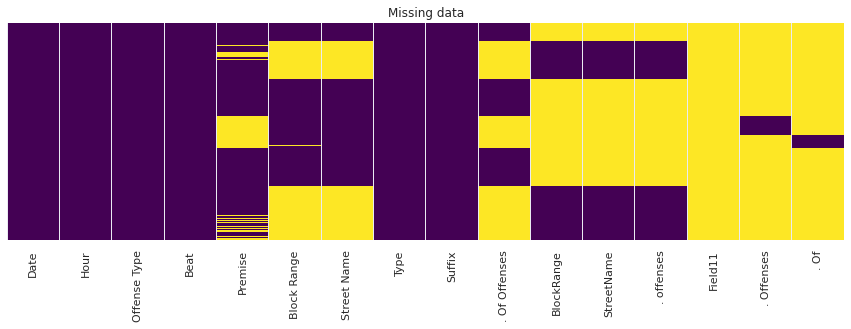

In [13]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Change Hour column errors

In [14]:
df['Hour'].unique()

array(['17', '05', '18', '03', '06', '21', '13', '14', '02', '23', '12',
       '00', '08', '19', '20', '01', '09', '16', '15', '10', '22', '07',
       '11', '04', '24', "'15", "'07", "'19", "'18", "'00", "'05", "'13",
       "'14", "'22", "'23", "'20", "'16", "'17", "'06", "'03", "'01",
       "'09", "'02", "'10", "'11", "'12", "'21", "'08", "'04"],
      dtype=object)

In [15]:
len(df['Hour'].unique())

49

In [16]:
df['Hour'] =  df['Hour'].str.replace('\'', '')

# TODO
# replace 00 to 24
df['Hour'].unique()

array(['17', '05', '18', '03', '06', '21', '13', '14', '02', '23', '12',
       '00', '08', '19', '20', '01', '09', '16', '15', '10', '22', '07',
       '11', '04', '24'], dtype=object)

In [17]:
len(df['Hour'].unique())

25

In [39]:
# Change hour to int
df['Hour'] = df['Hour'].astype('int64')

## Change column names and drop unused

In [18]:
df['block_range'] = pd.concat([df['Block Range'].dropna(),
                              df['BlockRange'].dropna()]).reindex_like(df)


df['street_name'] = pd.concat([df['Street Name'].dropna(),
                              df['StreetName'].dropna()]).reindex_like(df)


df['offenses'] = pd.concat([df['. Of Offenses'].dropna(),
                              df['. offenses'].dropna(),
                              df['. Offenses'].dropna(),
                              df['. Of'].dropna()]).reindex_like(df)


# drop unused cols
df = df.drop([  'Block Range','BlockRange','Street Name','StreetName','. Of Offenses','. offenses','. Offenses','. Of','Field11',
], axis = 1)






In [19]:
## cleanup col names
df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('\n','_').str.strip()

In [20]:
df.apply(lambda x: sum(x.isnull()))

date                4
hour                0
offense_type        0
beat               16
premise         29581
type                0
suffix              0
block_range       157
street_name         0
offenses            0
dtype: int64

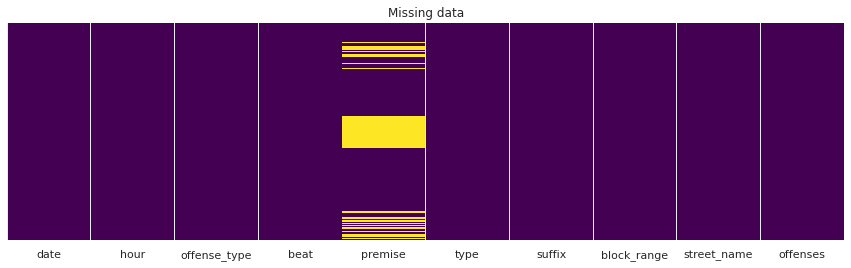

In [21]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

In [24]:
df[df.date.isna()]

,date,hour,offense_type,beat,premise,type,suffix,block_range,street_name,offenses
54412,NaT,15,Theft,13D40,NaN,PKWY,S,8500-8599,SAM HOUSTON,1.0
56526,NaT,14,Robbery,18F40,NaN,RD,-,2700-2799,DUNVALE,1.0
64547,NaT,08,Burglary,14D40,NaN,RD,-,5600-5699,SELINSKY,1.0
69191,NaT,11,Theft,7C20,NaN,-,-,3900-3999,CAVALCADE,1.0


## Drop cols with null date

In [25]:
# remove values with nat date
df = df[~df.date.isna()].reset_index(drop=True)

In [26]:
df[df.premise.isna()]

,date,hour,offense_type,beat,premise,type,suffix,block_range,street_name,offenses
10412,2014-08-08,18,Aggravated Assault,10H10,NaN,-,-,5300-5399,HARRISBURG,1.0
10419,2014-08-23,00,Theft,10H10,NaN,ST,N,UNK,ENNIS,1.0
10420,2014-08-25,12,Theft,10H10,NaN,DR,-,100-199,LOCKWOOD,1.0
10423,2014-08-02,18,Theft,10H10,NaN,ST,-,200-299,ROBERTS,1.0
10448,2014-07-27,15,Aggravated Assault,10H10,NaN,-,-,3900-3999,BERING,1.0
...,...,...,...,...,...,...,...,...,...,...
121732,2014-09-27,02,Aggravated Assault,UNK,NaN,-,W,700-799,FM 1960,1.0
121735,2014-09-07,11,Theft,UNK,NaN,RD,-,500-599,MARSHALL,1.0
121736,2014-09-04,15,Theft,UNK,NaN,BYP,W,9400-9499,FM 1960,1.0
121739,2014-09-14,19,Theft,UNK,NaN,PKWY,-,12600-12699,LAKE HOUSTON,1.0


In [27]:
## Change null values to UNK

df["premise"].fillna("UNK", inplace = True)

In [29]:
df[df.block_range.isna()]

,date,hour,offense_type,beat,premise,type,suffix,block_range,street_name,offenses
52633,2014-07-22,20,Theft,NaN,UNK,-,-,NaN,WALKER,1.0
52635,2014-07-16,13,Theft,NaN,UNK,-,-,NaN,PEASE,1.0
52654,2014-07-27,07,Burglary,10H10,UNK,-,-,NaN,212.5 LENOX,1.0
53200,2014-07-02,12,Auto Theft,10H80,UNK,-,-,NaN,2600 DUNLAVY + WESTHEIMER,1.0
53518,2014-07-12,11,Theft,12D10,UNK,DR,-,NaN,EDGEBROOK,1.0
...,...,...,...,...,...,...,...,...,...,...
70480,2014-06-28,09,Theft,20G50,UNK,-,-,NaN,800 TOWN AND COUNTRY (PV BLVD,1.0
70488,2014-06-28,23,Auto Theft,17E40,UNK,-,-,NaN,6334CREEKBEND,1.0
70524,2014-06-03,17,Theft,1A10,UNK,-,-,NaN,26TH ST / BEVIS ST,1.0
70538,2014-06-19,01,Burglary,8C10,UNK,ST,-,NaN,2 DENMARK,1.0


In [30]:
## Change null values to UNK

df["block_range"].fillna("UNK", inplace = True)

In [33]:
df[df.beat.isna()]

,date,hour,offense_type,beat,premise,type,suffix,block_range,street_name,offenses
52628,2014-07-19,11,Theft,NaN,UNK,-,-,2100-2199,VINTAGE,1.0
52629,2014-07-13,08,Theft,NaN,UNK,-,-,500-599,W.38TH,1.0
52630,2014-07-26,15,Rape,NaN,UNK,-,-,6100-6199,ATTWATER,1.0
52631,2014-07-13,15,Theft,NaN,UNK,-,W,7800-7899,FM 1960,1.0
52632,2014-07-14,09,Theft,NaN,UNK,LN,-,6600-6699,MERRY,1.0
52633,2014-07-22,20,Theft,NaN,UNK,-,-,UNK,WALKER,1.0
52634,2014-07-03,02,Theft,NaN,UNK,-,-,8400-8499,S. GESSNER,1.0
52635,2014-07-16,13,Theft,NaN,UNK,-,-,UNK,PEASE,1.0
52636,2014-07-26,14,Rape,NaN,UNK,-,-,6100-6199,ATTWATER,1.0
52637,2014-07-10,20,Theft,NaN,UNK,-,-,800-899,GESSNER SUITE 970,1.0


In [34]:
## Change null values to UNK

df["beat"].fillna("UNK", inplace = True)

In [36]:
df.apply(lambda x: sum(x.isnull()))

date            0
hour            0
offense_type    0
beat            0
premise         0
type            0
suffix          0
block_range     0
street_name     0
offenses        0
dtype: int64

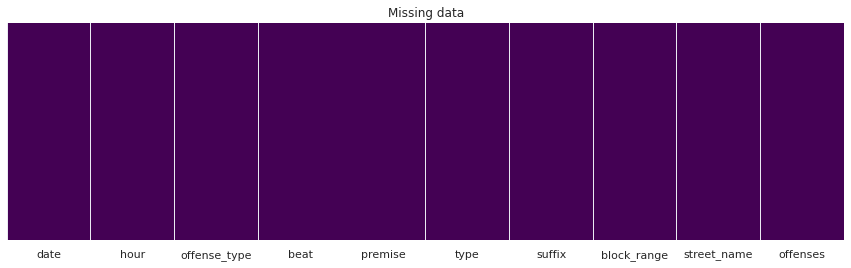

In [37]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Combine columns 

## Combine date & hour to one column

In [40]:
# convert two columns into one datetime
df['date_time'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')

# drop columns
df = df.drop(['date','hour'], axis = 1)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121746 entries, 0 to 121745
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   offense_type  121746 non-null  object        
 1   beat          121746 non-null  object        
 2   premise       121746 non-null  object        
 3   type          121746 non-null  object        
 4   suffix        121746 non-null  object        
 5   block_range   121746 non-null  object        
 6   street_name   121746 non-null  object        
 7   offenses      121746 non-null  float64       
 8   date_time     121746 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 8.4+ MB


In [42]:
df.head()

,offense_type,beat,premise,type,suffix,block_range,street_name,offenses,date_time
0,Murder,14D30,18D,BLVD,-,8500-8599,MARTIN LUTHER KING,1.0,2014-04-19 17:00:00
1,Murder,10H20,13R,ST,-,3600-3699,MCKINNEY,1.0,2014-04-28 05:00:00
2,Murder,5F30,20A,-,-,7400-7499,HILLMONT,3.0,2014-04-27 18:00:00
3,Murder,17E10,20A,-,-,5400-5499,RENWICK,2.0,2014-04-09 18:00:00
4,Murder,18F50,03B,AVE,-,9300-9399,RICHMOND,1.0,2014-04-24 03:00:00


## Convert offenses to integer

In [43]:
# convert offenses to int
df['offenses'] = df['offenses'].astype('int64')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121746 entries, 0 to 121745
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   offense_type  121746 non-null  object        
 1   beat          121746 non-null  object        
 2   premise       121746 non-null  object        
 3   type          121746 non-null  object        
 4   suffix        121746 non-null  object        
 5   block_range   121746 non-null  object        
 6   street_name   121746 non-null  object        
 7   offenses      121746 non-null  int64         
 8   date_time     121746 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 8.4+ MB


## change order of columns

In [45]:
col_ord =['date_time','offenses','offense_type', 'block_range', 'street_name', 'type', 'suffix','beat', 'premise']
df = df[col_ord]
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise
0,2014-04-19 17:00:00,1,Murder,8500-8599,MARTIN LUTHER KING,BLVD,-,14D30,18D
1,2014-04-28 05:00:00,1,Murder,3600-3699,MCKINNEY,ST,-,10H20,13R
2,2014-04-27 18:00:00,3,Murder,7400-7499,HILLMONT,-,-,5F30,20A
3,2014-04-09 18:00:00,2,Murder,5400-5499,RENWICK,-,-,17E10,20A
4,2014-04-24 03:00:00,1,Murder,9300-9399,RICHMOND,AVE,-,18F50,03B


## Save to bucket

In [46]:
bucket = 'salas-data'
file_name = f'crime_{year}.csv'
path_to_save = f"s3://{bucket}/capstone/inter-data/crime-data/{file_name}"
path_to_save

's3://salas-data/capstone/inter-data/crime-data/crime_2014.csv'

In [47]:
%%time
wr.s3.to_csv(df, path_to_save, index=False)

CPU times: user 484 ms, sys: 31.2 ms, total: 516 ms
Wall time: 7.1 s


{'paths': ['s3://salas-data/capstone/inter-data/crime-data/crime_2014.csv'],
 'partitions_values': {}}